In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(13, 7))
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
from scipy import stats

from pandas.plotting import register_matplotlib_converters
#from statsmodels.tsa.api import Holt

#from acquire import get_store_data, opsd_germany_daily
#import prepare

In [2]:
cny = pd.read_csv('yuan-usd.csv',sep=',', skipinitialspace=True)
cny.head()

,date,value
0,1981-01-02,1.53
1,1981-01-05,1.54
2,1981-01-06,1.53
3,1981-01-07,1.53
4,1981-01-08,1.53


In [3]:
cny = cny[~(cny['date'] < '2015-12-04')]

In [4]:
cny

,date,value
8715,2015-12-04,6.3900
8716,2015-12-07,6.4100
8717,2015-12-08,6.4200
8718,2015-12-09,6.4300
8719,2015-12-10,6.4400
...,...,...
10126,2020-11-30,6.5789
10127,2020-12-01,6.5723
10128,2020-12-02,6.5634
10129,2020-12-03,6.5429


In [27]:
cny.drop(columns=['date'], inplace=True)

,value
8715,6.3900
8716,6.4100
8717,6.4200
8718,6.4300
8719,6.4400
...,...
10126,6.5789
10127,6.5723
10128,6.5634
10129,6.5429


In [6]:
btc = pd.read_csv('BTC-USD.csv',sep=',', skipinitialspace=True)
btc


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-04,361.261993,363.515991,355.756989,363.183014,363.183014,35784100
1,2015-12-05,363.721008,389.785004,363.229004,388.949005,388.949005,66282200
2,2015-12-06,389.554993,402.808990,387.088989,388.782990,388.782990,77762000
3,2015-12-07,389.977997,399.968994,385.411011,395.536011,395.536011,63455800
4,2015-12-08,395.753998,415.562988,389.950012,415.562988,415.562988,57801400
...,...,...,...,...,...,...,...
1823,2020-11-30,18178.322266,19749.263672,18178.322266,19625.835938,19625.835938,47728480399
1824,2020-12-01,19633.769531,19845.974609,18321.921875,18802.998047,18802.998047,49633658712
1825,2020-12-02,18801.744141,19308.330078,18347.718750,19201.091797,19201.091797,37387697138
1826,2020-12-03,19205.925781,19566.191406,18925.785156,19445.398438,19445.398438,31930317405


In [7]:

#btc.Date = pd.to_datetime(btc.Date)

btc.drop(columns = ['Adj Close',
                  'Open',
                  'High',
                  'Low',
                   'Volume'], inplace = True)

In [8]:
btc

,Date,Close
0,2015-12-04,363.183014
1,2015-12-05,388.949005
2,2015-12-06,388.782990
3,2015-12-07,395.536011
4,2015-12-08,415.562988
...,...,...
1823,2020-11-30,19625.835938
1824,2020-12-01,18802.998047
1825,2020-12-02,19201.091797
1826,2020-12-03,19445.398438


In [31]:
btc.drop(columns=['Date'], inplace=True)

In [18]:
scaler = sklearn.preprocessing.MinMaxScaler()

In [21]:
btc.Date = pd.to_datetime(btc.Date)

In [32]:
scaler.fit(btc)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [29]:
scaler.fit(cny)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [30]:
cny_scaled = scaler.transform(cny)

In [37]:
cny_scaled

array([[0.13685592],
       [0.15873537],
       [0.16967509],
       ...,
       [0.32655071],
       [0.30412428],
       [0.29176239]])

In [33]:
btc_scaled = scaler.transform(btc)

In [45]:
btc_s = pd.DataFrame(btc_scaled)

In [46]:
cny_s = pd.DataFrame(cny_scaled)

No handles with labels found to put in legend.


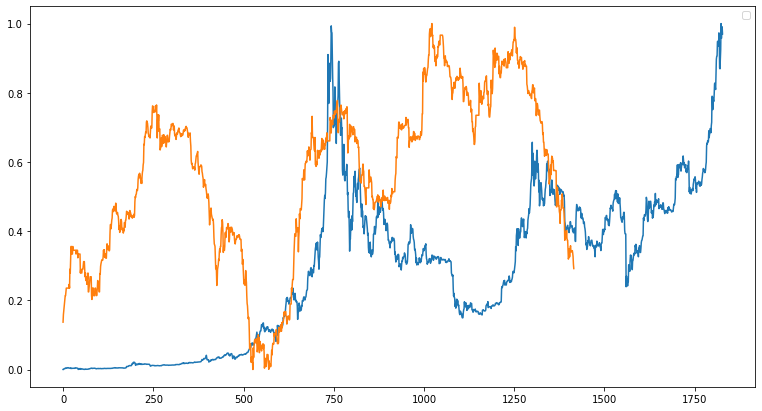

In [50]:
plt.plot(btc_s)
plt.plot(cny_s)
plt.legend(loc='best')
plt.show()

In [38]:
btc_scaled.plot.line()
cny_scaled.plot.line()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

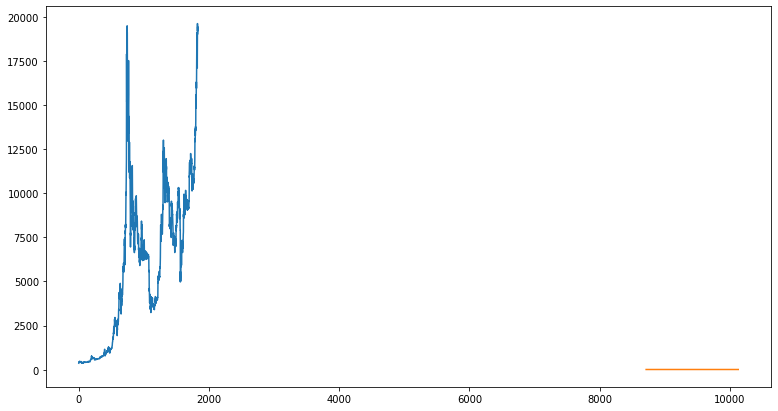